This notebook goes over converting the data to tabular format for passing to model.  It was exported from emacs org-mode hence some formating may be off.

Work here was done in Julia 0.7.0. Calls to PyCall uses a python 3.6.5 backend.

In [ ]:
using Queryverse, JuliaDB

In [1]:
datadir = "/home/ishai/Documents/work/marketbot/src/utils/data/raw"
run(`ls -lh $(datadir)`)

total 46M
-rw-rw-r-- 1 ishai ishai 2.5M Aug 14 00:12 20180813-171152.csv
-rw-rw-r-- 1 ishai ishai 1.7M Aug 14 02:50 20180814-001303.csv
-rw-rw-r-- 1 ishai ishai 1.7M Aug 15 03:42 20180815-004411.csv
-rw-rw-r-- 1 ishai ishai 1.6M Aug 15 12:38 20180815-113032.csv
-rw-rw-r-- 1 ishai ishai 457K Aug 15 13:46 20180815-131857.csv
-rw-rw-r-- 1 ishai ishai  14K Aug 15 13:48 20180815-134729.csv
-rw-rw-r-- 1 ishai ishai 1.1M Aug 15 15:15 20180815-134950.csv
-rw-rw-r-- 1 ishai ishai  37M Aug 18 01:37 20180815-160006.csv

In [1]:
fname = maximum(readdir(datadir))
run(`head $(joinpath(datadir, fname))`)

2018-08-15T20:00:07.341000Z,289.01000000,0.95307512,ETH-USD
2018-08-15T20:00:07.878000Z,6383.82000000,0.05064896,BTC-USD
2018-08-15T20:00:07.878000Z,6383.82000000,0.06453496,BTC-USD
2018-08-15T20:00:08.441000Z,6383.81000000,1.52758604,BTC-USD
2018-08-15T20:00:08.441000Z,6383.81000000,1.75478104,BTC-USD
2018-08-15T20:00:08.441000Z,6383.81000000,0.00118000,BTC-USD
2018-08-15T20:00:08.441000Z,6383.81000000,0.56368644,BTC-USD
2018-08-15T20:00:08.441000Z,6383.81000000,0.03650000,BTC-USD
2018-08-15T20:00:08.441000Z,6383.81000000,0.00810000,BTC-USD
2018-08-15T20:00:08.441000Z,6383.81000000,0.00380000,BTC-USD

In [1]:
using Dates
colnames = ["date", "price", "size", "product_id"]
t = Queryverse.load(joinpath(datadir, fname),
                    colnames=colnames,
                    colparsers=Dict(:date=>String, :price=>Float64, :size=>Float64, :product_id=>String)) |>
                        @map({:date=>DateTime(_.date[1:end-5]), _.price, _.size, _.product_id}) |> # cast to DateTime
                        table

# Out[6]:
#+BEGIN_EXAMPLE
  Table with 623229 rows, 4 columns:
  date                    price    size        product_id
  ───────────────────────────────────────────────────────
  2018-08-15T20:00:07.87  6383.82  0.050649    "BTC-USD"
  2018-08-15T20:00:07.87  6383.82  0.064535    "BTC-USD"
  2018-08-15T20:00:08.44  6383.81  1.52759     "BTC-USD"
  2018-08-15T20:00:08.44  6383.81  1.75478     "BTC-USD"
  2018-08-15T20:00:08.44  6383.81  0.00118     "BTC-USD"
  2018-08-15T20:00:08.44  6383.81  0.563686    "BTC-USD"
  2018-08-15T20:00:08.44  6383.81  0.0365      "BTC-USD"
  2018-08-15T20:00:08.44  6383.81  0.0081      "BTC-USD"
  2018-08-15T20:00:08.44  6383.81  0.0038      "BTC-USD"
  2018-08-15T20:00:08.44  6383.81  0.2         "BTC-USD"
  2018-08-15T20:00:08.44  6383.81  0.00998106  "BTC-USD"
  2018-08-15T20:00:08.44  6383.81  0.0633251   "BTC-USD"
  ⋮
  2018-08-18T05:37:32.6   310.51   1.3413      "ETH-USD"
  2018-08-18T05:37:32.6   310.5    8.46415     "ETH-USD"
  2018-08-18T05:37:

Assign primary keys



In [1]:
t = table(t, pkey=(:product_id, :date))

Lets check if the data is sorted with in groups.



In [1]:
a = t |> @groupby(_.product_id, _.date) |> @map({origin=key(_), result=issorted(_)}) |> @map(all(_.result))
all(a)

# Out[11]:
true

This opens a new window



In [1]:
t |> Voyager()

![img](./voyager.png)

The default view doesn't work for volume (size), lets try line instead



# Out[16]:

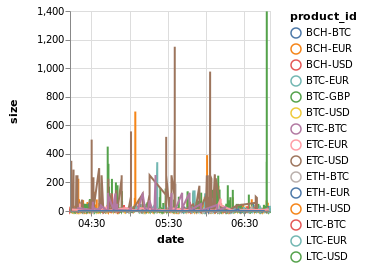

In [1]:
@time t |> @vlplot(:line, x=:date, y=:size, color="product_id")

Not that nice. 



In [1]:
tdiff = t |> @filter(_.product_id=="ETH-USD") |> @map(_.date) |> collect |> diff |> @map({delta=_});
tdiff |> @map({delta=log(Dates.value(_.delta))}) |> @vlplot(mark={:bar, clip=true}, x={:delta, bin={maxbins=1000}, scale={domain=[0,15], clip=true}}, y={"count()", axis={title="Time-difference counts"}})

Plot time differences between observations



# Out[136]:

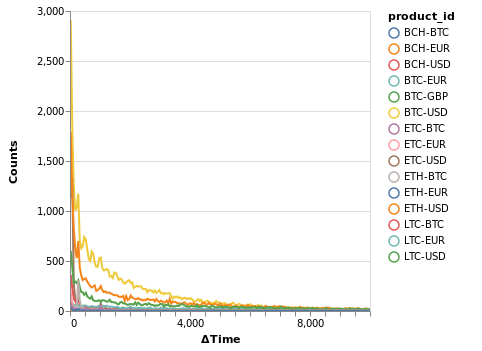

In [1]:
t |>
    @groupby(_.product_id) |>
    @map({product_id=key(_), delta=diff(_.date)}) |>
    @mapmany(_.delta, {delta=Dates.value(__), product_id=_.product_id}) |> # __ is the individual element in row
    @filter(_.delta>0) |>
    @vlplot(mark={:line, clip=true},
            x={:delta, axis={title="ΔTime"}, bin={maxbins=100000}, scale={domain=[0,10000], clip=true}},
            y={"count()", axis={title="Counts"}  #, scale={domain=[0,100], clip=true}
               },
            color=:product_id,
            height=300,
            width=300)

*log* time differences (between observations)



# Out[34]:

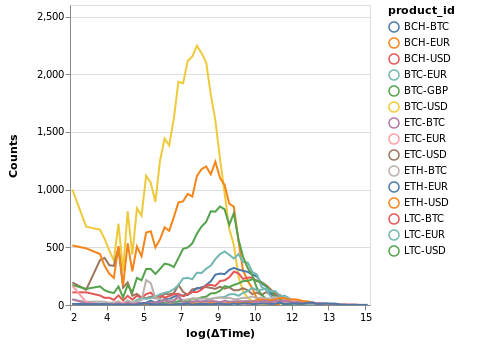

In [1]:
t |>
    @groupby(_.product_id) |>
    @map({product_id=key(_), delta=diff(_.date)}) |>
    @mapmany(_.delta, {delta=__, product_id=_.product_id}) |> # __ is the individual element in row
    @map({_.product_id, delta=log(Dates.value(_.delta))}) |>
    @vlplot(mark={:line, clip=true},
            x={:delta, axis={title="log(ΔTime)"}, bin={maxbins=100}},
            y={"count()", axis={title="Counts"}, scale={domain=[0,2500], clip=true}},
            color=:product_id, height=300, width=300)

Irregular signal. Resample to have observations at regular intervals.

Review duplicates:



In [1]:
t |> @groupby((_.product_id, _.date)) |> @map({origin=key(_), Count=length(_)}) |> @filter(_.Count > 1)

# Out[41]:
#+BEGIN_EXAMPLE
  ?x2 query result
  origin                              │ Count
  ────────────────────────────────────┼──────
  ("BTC-USD", 2018-08-15T20:00:07.87) │ 2
  ("BTC-USD", 2018-08-15T20:00:08.44) │ 12
  ("BTC-USD", 2018-08-15T20:00:08.46) │ 2
  ("BTC-USD", 2018-08-15T20:00:11.05) │ 6
  ("ETH-USD", 2018-08-15T20:00:11.2)  │ 2
  ("BTC-USD", 2018-08-15T20:00:12.16) │ 4
  ("BTC-USD", 2018-08-15T20:00:12.93) │ 11
  ("BTC-USD", 2018-08-15T20:00:13.02) │ 2
  ("BTC-USD", 2018-08-15T20:00:14.43) │ 4
  ("ETH-EUR", 2018-08-15T20:00:17.29) │ 5
  ... with more rows
#+END_EXAMPLE

These are due to transactions that are cleared simultaneously.



In [1]:
using Statistics
t = t |> @groupby((_.product_id, _.date)) |> @map({product_id=key(_)[1], date=key(_)[2], price=median(_.price),  size=sum(_.size)}) |> table;

# Out[8]:

In [1]:
using Query, Statistics
t = @from i in t begin
    @group i by i.product_id, i.date into g
    @select {product_id=key(g)[1], date=key(g)[2], price=median(g.price), size=sum(g.size)}
    @collect table
end

# Out[79]:
#+BEGIN_EXAMPLE
  Table with 351419 rows, 4 columns:
  product_id  date                    price    size
  ───────────────────────────────────────────────────────
  "BTC-USD"   2018-08-15T20:00:07.87  6383.82  0.115184
  "BTC-USD"   2018-08-15T20:00:08.44  6383.81  4.4218
  "BTC-USD"   2018-08-15T20:00:08.46  6383.58  0.001
  "BTC-USD"   2018-08-15T20:00:08.48  6383.35  0.00049985
  "BTC-USD"   2018-08-15T20:00:08.56  6382.54  0.00810663
  "BTC-USD"   2018-08-15T20:00:08.61  6382.53  0.00105
  "ETC-USD"   2018-08-15T20:00:09.78  12.11    72.8834
  "ETH-USD"   2018-08-15T20:00:10.48  289.01   2.1008
  "BTC-USD"   2018-08-15T20:00:11.05  6374.65  0.197664
  "ETH-USD"   2018-08-15T20:00:11.2   289.0    0.51067
  "BTC-USD"   2018-08-15T20:00:12.16  6373.0   2.0
  "BTC-USD"   2018-08-15T20:00:12.93  6374.29  1.68051
  ⋮
  "ETH-USD"   2018-08-18T05:37:24.32  310.85   4.9996
  "ETC-USD"   2018-08-18T05:37:29.94  14.195   74.6061
  "ETH-USD"   2018-08-18T05:37:32.6   310.52   11.9
 

In [1]:
t |> @groupby((_.product_id, _.date)) |> @map({origin=key(_), Count=length(_)}) |> @filter(_.Count > 1)

# Out[10]:
#+BEGIN_EXAMPLE
  0x2 query result
  origin │ Count
  ───────┼──────
#+END_EXAMPLE

# Out[94]:

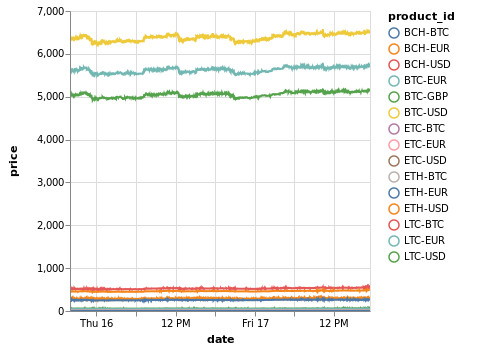

In [1]:
t |> @vlplot(mark={:line, clip=true},
             x={:date},
             y={:price},
             color=:product_id, height=300, width=300)

Median time difference:



In [1]:
meddiff = t |> @groupby(_.product_id, _.date) |> @map({key(_), median(diff(Dates.values(Float64.(_))))}) |> DataFrame

# Out[151]:
#+BEGIN_EXAMPLE
  15×2 DataFrames.DataFrame
  │ Row │ key     │ _2_     │
  ├─────┼─────────┼─────────┤
  │ 1   │ BTC-USD │ 1190.0  │
  │ 2   │ ETC-USD │ 890.0   │
  │ 3   │ ETH-USD │ 1780.0  │
  │ 4   │ ETH-EUR │ 8850.0  │
  │ 5   │ BCH-USD │ 6360.0  │
  │ 6   │ LTC-BTC │ 24825.0 │
  │ 7   │ BTC-EUR │ 5910.0  │
  │ 8   │ LTC-USD │ 3090.0  │
  │ 9   │ BTC-GBP │ 15390.0 │
  │ 10  │ LTC-EUR │ 18665.0 │
  │ 11  │ ETH-BTC │ 3595.0  │
  │ 12  │ ETC-EUR │ 29360.0 │
  │ 13  │ BCH-EUR │ 38610.0 │
  │ 14  │ ETC-BTC │ 3990.0  │
  │ 15  │ BCH-BTC │ 16330.0 │
#+END_EXAMPLE

In [1]:
t = setcol(t, :datevalue, Queryverse.map(r->Dates.value(r.date), t))
mindate = minimum(JuliaDB.select(t, :datevalue))
t = setcol(t, :datevalue, Queryverse.map(r->r.datevalue-mindate, t))

# Out[9]:
#+BEGIN_EXAMPLE
  Table with 351419 rows, 5 columns:
  product_id  date                    price    size        datevalue
  ──────────────────────────────────────────────────────────────────
  "BTC-USD"   2018-08-15T20:00:07.87  6383.82  0.115184    0
  "BTC-USD"   2018-08-15T20:00:08.44  6383.81  4.4218      570
  "BTC-USD"   2018-08-15T20:00:08.46  6383.58  0.001       590
  "BTC-USD"   2018-08-15T20:00:08.48  6383.35  0.00049985  610
  "BTC-USD"   2018-08-15T20:00:08.56  6382.54  0.00810663  690
  "BTC-USD"   2018-08-15T20:00:08.61  6382.53  0.00105     740
  "ETC-USD"   2018-08-15T20:00:09.78  12.11    72.8834     1910
  "ETH-USD"   2018-08-15T20:00:10.48  289.01   2.1008      2610
  "BTC-USD"   2018-08-15T20:00:11.05  6374.65  0.197664    3180
  "ETH-USD"   2018-08-15T20:00:11.2   289.0    0.51067     3330
  "BTC-USD"   2018-08-15T20:00:12.16  6373.0   2.0         4290
  "BTC-USD"   2018-08-15T20:00:12.93  6374.29  1.68051     5060
  ⋮
  "ETH-USD"   2018-08-18T05:37:24.3

Lowest median time difference between samples is for BCH-EUR at around 38 seconds between observations. Still, try using .5 second sampling frequency to take advantage of higher frequency signals.

Start and end of interval



In [1]:
sampling_rate = 500
tstart = minimum(JuliaDB.select(t, :datevalue))
tend = maximum(JuliaDB.select(t, :datevalue))
sample_points = tstart:sampling_rate:tend # iterating in milliseconds

# Out[10]:
0:500:207449000

Aggregate values in interval



In [1]:
t = setcol(t, :dateval_rounded, ceil.(Int64, JuliaDB.select(t, :datevalue) ./ sampling_rate) .* sampling_rate)

In [1]:
tnew = t |> @groupby((_.product_id, _.dateval_rounded)) |> @map({product_id=key(_)[1], dateval=key(_)[2], price=median(_.price), size=sum(_.size)}) |> table

In [1]:
tmptbl = table(columns(table(map(t->(t, Missing, Missing), sample_points))), names=[:dateval, :price, :siz])
# tmptbl = table(collect(sample_points), names=[:dateval], pkey=:dateval)
tmpdf = DataFrame(Dict(:dateval=>collect(sample_points)))

In [1]:
tnew |> @groupby _.product_id |> @map(join(DataFrame(_),tmpdf, on :dataeval))

In [1]:
tnew |> @groupby _.product_id |> @map({:product_id=key(_), :datevalue=sample_points, :price=})

In [1]:
@apply tnew :product_id begin
    @where x in 
    sort(_, :dateval_rounded) 
    tnew |> @groupby(())

Apply function across groups and unstack.



In [1]:
tnew = JuliaDB.groupby(date_interp_t, t, :product_id, flatten=true)
tnew = IndexedTables.unstack(table(tnew), :datevalue; variable=:product_id, value=:price)

In [1]:
using Dierckx, NamedTuples
date_interp(x, y) = Spline1D(x,y; k=2, bc="extrapolate", s=1e-4)(sample_points)
date_interp_t(_t) = table(@NT(datevalue=sample_points, price=date_interp(JuliaDB.select(_t, :datevalue), JuliaDB.select(_t, :price))))
# date_interp_t(_t) = date_interp(_t[:datevalue], _t[:price])

# Out[262]:
date_interp_t (generic function with 1 method)

In [1]:
using Interpolations, NamedTuples
date_interp(x, y) = LinearInterpolation(x,y, extrapolation_bc=Linear())(collect(sample_points))
date_interp_t(_t) = table(@NT(datevalue=sample_points .- minimum(sample_points), price=date_interp(IndexedTables.select(table(_t), :datevalue), IndexedTables.select(table(_t), :price))))

# Out[264]:
date_interp_t (generic function with 1 method)

# Out[265]:

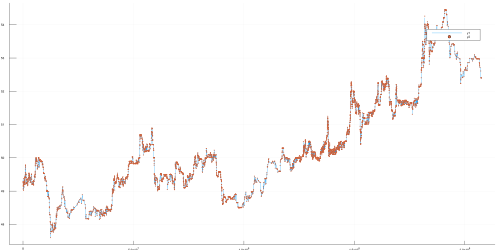

In [1]:
using StatPlots
temp = t |> @filter(_.product_id =="BCH-BTC") |> table |> date_interp_t;
temp2 = t |> @filter(_.product_id =="BCH-BTC") |> table;
@df temp plot(:datevalue, :price, size=(2000,1000))
@df temp2 scatter!(:datevalue, :price, markersize=1)

Apply function across groups and unstack.



In [1]:
tnew = JuliaDB.groupby(date_interp_t, t, :product_id, flatten=true)
tnew = IndexedTables.unstack(table(tnew), :datevalue; variable=:product_id, value=:price)

# Out[267]:
#+BEGIN_EXAMPLE
  Table with 414899 rows, 16 columns:
  Columns:
  #   colname    type
  ─────────────────────────────────
  1   datevalue  Int64
  2   BCH-BTC    DataValue{Float64}
  3   BCH-EUR    DataValue{Float64}
  4   BCH-USD    DataValue{Float64}
  5   BTC-EUR    DataValue{Float64}
  6   BTC-GBP    DataValue{Float64}
  7   BTC-USD    DataValue{Float64}
  8   ETC-BTC    DataValue{Float64}
  9   ETC-EUR    DataValue{Float64}
  10  ETC-USD    DataValue{Float64}
  11  ETH-BTC    DataValue{Float64}
  12  ETH-EUR    DataValue{Float64}
  13  ETH-USD    DataValue{Float64}
  14  LTC-BTC    DataValue{Float64}
  15  LTC-EUR    DataValue{Float64}
  16  LTC-USD    DataValue{Float64}
#+END_EXAMPLE

In [1]:
tnew[end-100:end] |> DataFrame |> tail

# Out[268]:
#+BEGIN_EXAMPLE
  6×16 DataFrame. Omitted printing of 9 columns
  │ Row │ datevalue │ BCH-BTC │ BCH-EUR │ BCH-USD │ BTC-EUR │ BTC-GBP │ BTC-USD │
  ├─────┼───────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
  │ 1   │ 207446500 │ 0.09069 │ 520.15  │ 589.46  │ 5709.16 │ 5251.41 │ 6517.65 │
  │ 2   │ 207447000 │ 0.09069 │ 520.15  │ 589.46  │ 5709.16 │ 5252.02 │ 6517.65 │
  │ 3   │ 207447500 │ 0.09069 │ 520.15  │ 589.46  │ 5709.16 │ 5252.63 │ 6517.65 │
  │ 4   │ 207448000 │ 0.09069 │ 520.15  │ 589.46  │ 5709.16 │ 5253.23 │ 6517.65 │
  │ 5   │ 207448500 │ 0.09069 │ 520.15  │ 589.46  │ 5709.16 │ 5253.84 │ 6517.65 │
  │ 6   │ 207449000 │ 0.09069 │ 520.15  │ 589.46  │ 5709.16 │ 5254.44 │ 6517.65 │
#+END_EXAMPLE

In [1]:
showcols(DataFrame(tnew))

# Out[22]:
#+BEGIN_EXAMPLE
  16×5 DataFrame
  │ Row │ variable  │ eltype  │ nmissing │ first     │ last       │
  ├─────┼───────────┼─────────┼──────────┼───────────┼────────────┤
  │ 1   │ datevalue │ Float64 │          │ 6.367e13  │ 6.36703e13 │
  │ 2   │ BCH-BTC   │ Float64 │ 0        │ 0.0808327 │ 0.09069    │
  │ 3   │ BCH-EUR   │ Float64 │ 0        │ 458.773   │ 520.15     │
  │ 4   │ BCH-USD   │ Float64 │ 0        │ 519.021   │ 589.46     │
  │ 5   │ BTC-EUR   │ Float64 │ 0        │ 5622.95   │ 5709.16    │
  │ 6   │ BTC-GBP   │ Float64 │ 0        │ 5050.2    │ 5254.44    │
  │ 7   │ BTC-USD   │ Float64 │ 0        │ 6383.82   │ 6517.65    │
  │ 8   │ ETC-BTC   │ Float64 │ 0        │ 0.00191   │ 0.00217    │
  │ 9   │ ETC-EUR   │ Float64 │ 0        │ 10.757    │ 12.4522    │
  │ 10  │ ETC-USD   │ Float64 │ 0        │ 12.11     │ 14.2251    │
  │ 11  │ ETH-BTC   │ Float64 │ 0        │ 0.0451994 │ 0.04781    │
  │ 12  │ ETH-EUR   │ Float64 │ 0        │ 254.655   │ 273.216    │
  │ 

In [1]:
sum(isnan.(IndexedTables.select(tnew, :datevalue)))

# Out[269]:
0

Replace missing + mandatory column wise vs row wise comparison:



In [1]:
using Query
dfnew = tnew |> DataFrame
@time for i in size(dfnew)[1]-1:-1:1
    for c in 1:size(dfnew)[2]
        if isnan(dfnew[i,c])
            dfnew[i,c] = dfnew[i+1,c]
        end
    end
end

2.476500 seconds (16.17 M allocations: 367.061 MiB, 52.51% gc time)

In [1]:
using Query
dfnew = tnew |> DataFrame
@time for c in 1:size(dfnew)[2]
    for i in size(dfnew)[1]-1:-1:1
        if isnan(dfnew[i,c])
            dfnew[i,c] = dfnew[i+1,c]
        end
    end
end

1.876617 seconds (26.94 M allocations: 512.453 MiB, 23.32% gc time)

No more nulls



In [1]:
tnew |> @map(isnan.(values(_))) |> table |> columns |> @map(sum(_)) |> maximum

# Out[270]:
0

Save



In [1]:
# tnew |> save("postproc2.feather")
tnew |> save("postproc2.csv")

Annoyingly, there is some non-negligible loss in precision after saving the data



In [1]:
df = load("postproc2.csv") |> DataFrame
println(sum((convert(Array{Float64}, DataFrame(tnew)) .- convert(Array{Float64}, df)).^2, 1))

[3.04944 2.56476e-30 3.36042e-25 1.9387e-25 4.96308e-24 8.27181e-24 1.65436e-24 2.37737e-33 2.54644e-27 2.22143e-27 8.44039e-31 2.488e-25 2.55263e-25 6.31163e-32 4.29645e-26 3.1302e-26]
┌ Warning: `sum(a::AbstractArray, dims)` is deprecated, use `sum(a, dims=dims)` instead.
│   caller = top-level scope at In[108]:1
└ @ Core In[108]:1

*3.04944* - sum of squares for datevalue is non-negligible. Maybe because saved as csv or because originally used float64 for dateavalue.



In [1]:
maximum(diff(df[:datevalue])), minimum(diff(df[:datevalue]))

# Out[149]:
(500.015625, 499.984375)

Probably should have converted it to Int64



In [1]:
maximum(diff(convert(Array{Float64}, df), 1)[:,2:end], 1)

# Out[157]:
#+BEGIN_EXAMPLE
  1×15 Array{Float64,2}:
  0.000302757  2.05052  1.69563  23.0194  …  1.11495  2.0e-5  0.208  0.164176
#+END_EXAMPLE

Can probably use a better smoothing approach here.

Using Feather api directly seems to work



In [1]:
using Feather
Feather.write("postproc3.feather", DataFrame(tnew))

In [1]:
load("postproc3.feather") |> @map(isnan.(values(_))) |> table |> columns |> @map(sum(_)) |> maximum

# Out[285]:
0

In [1]:
df = load("postproc3.feather") |> DataFrame
println(sum((convert(Array{Float64}, DataFrame(tnew)) .- convert(Array{Float64}, df)).^2, 1))

[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
┌ Warning: `sum(a::AbstractArray, dims)` is deprecated, use `sum(a, dims=dims)` instead.
│   caller = top-level scope at In[289]:2
└ @ Core In[289]:2